# **Exploratory Data Analysis (EDA)**


=== Basic info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   20631 non-null  int64  
 1   cycle                                    20631 non-null  int64  
 2   setting_1                                20631 non-null  float64
 3   setting_2                                20631 non-null  float64
 4   (LPC outlet temperature) (◦R)            20631 non-null  float64
 5   (HPC outlet temperature) (◦R)            20631 non-null  float64
 6   (LPT outlet temperature) (◦R)            20631 non-null  float64
 7   (bypass-duct pressure) (psia)            20631 non-null  float64
 8   (HPC outlet pressure) (psia)             20631 non-null  float64
 9   (Physical fan speed) (rpm)               20631 non-null  float64
 10  (Physical core speed) (rpm

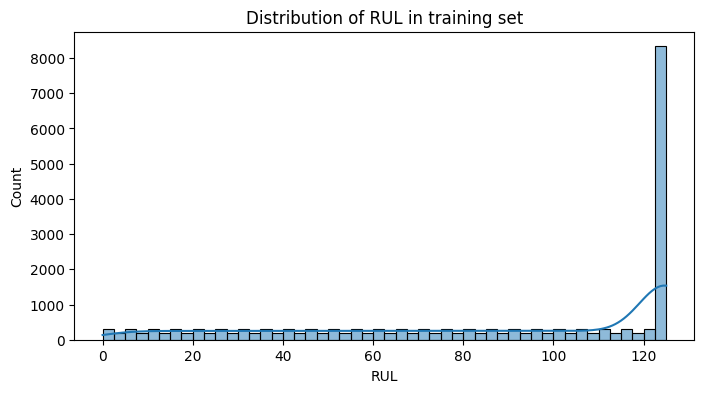

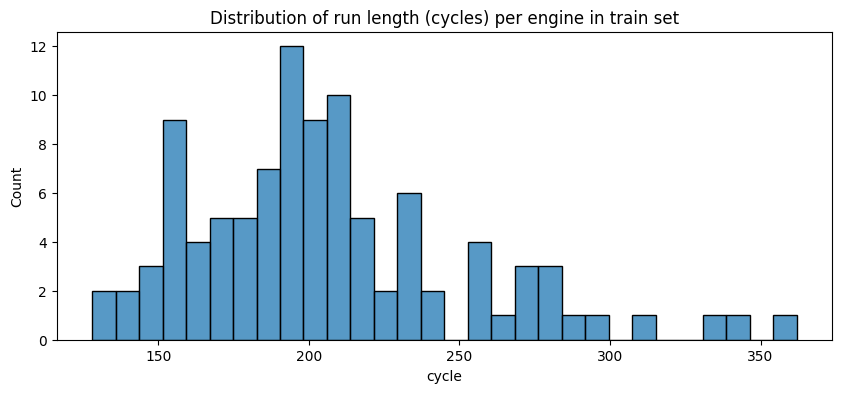

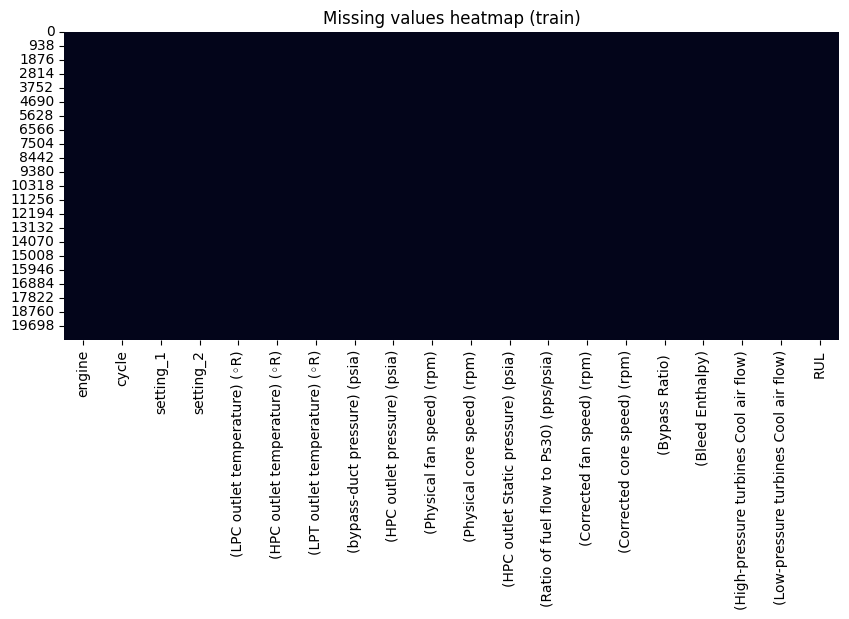


Top 12 features by absolute correlation with RUL:
(HPC outlet Static pressure) (psia)        0.775230
(LPT outlet temperature) (◦R)              0.757157
(Ratio of fuel flow to Ps30) (pps/psia)    0.748870
cycle                                      0.746939
(HPC outlet pressure) (psia)               0.733021
(Bypass Ratio)                             0.720858
(Low-pressure turbines Cool air flow)      0.707334
(High-pressure turbines Cool air flow)     0.704626
(Bleed Enthalpy)                           0.680829
(LPC outlet temperature) (◦R)              0.678458
(HPC outlet temperature) (◦R)              0.655030
(Physical fan speed) (rpm)                 0.624568
Name: RUL, dtype: float64


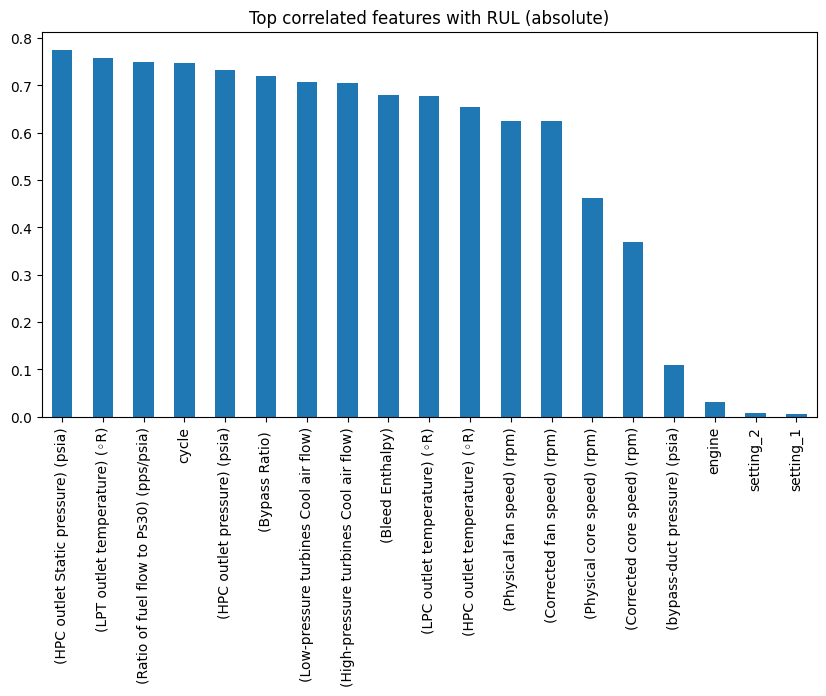

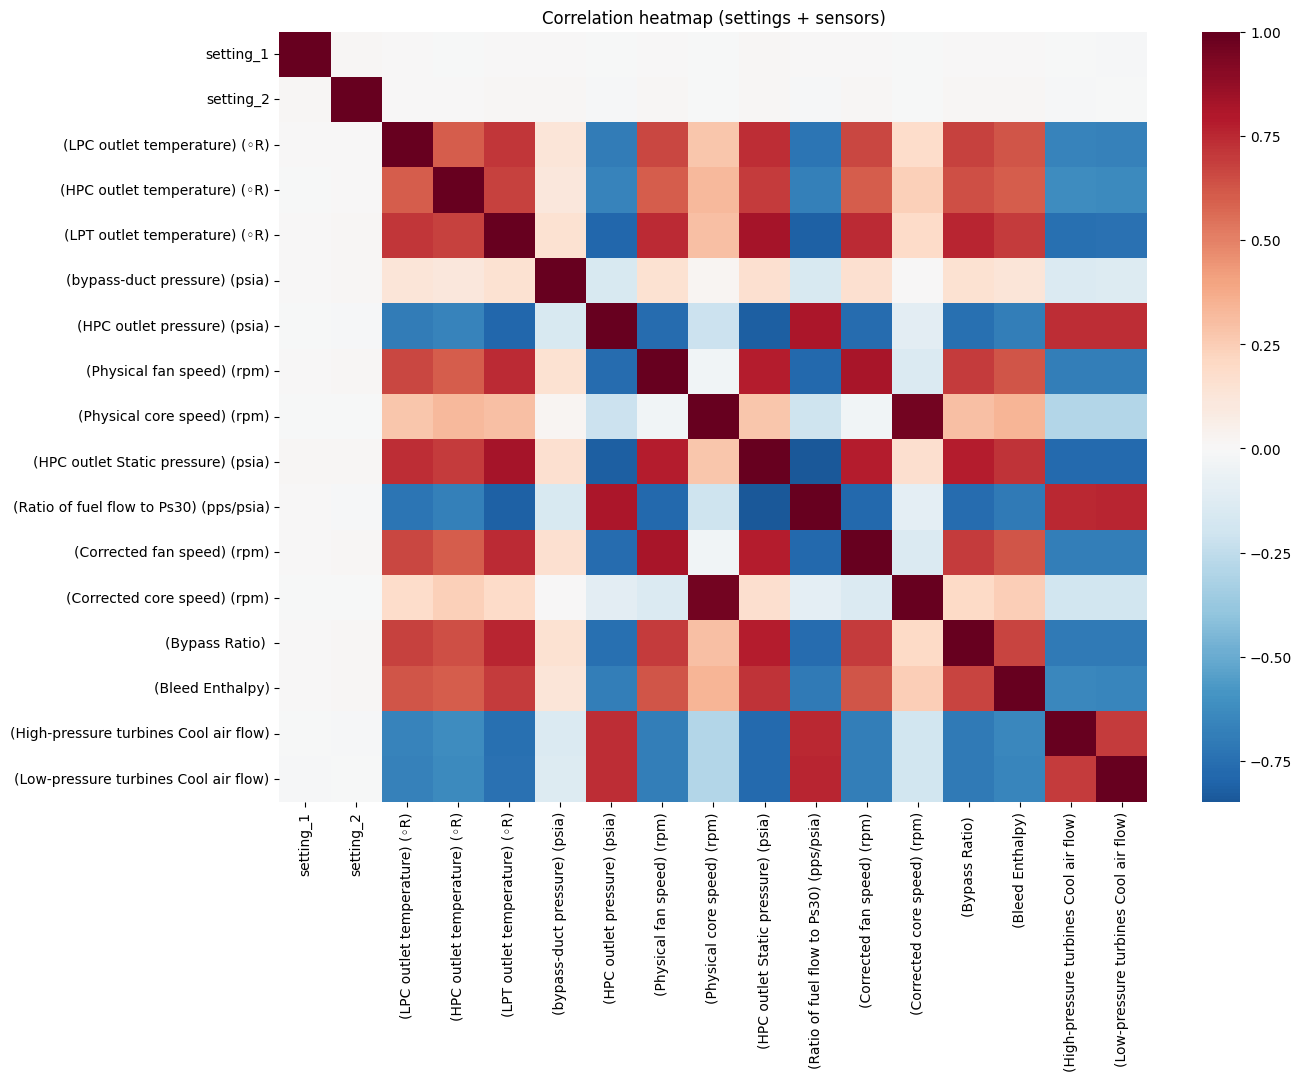


Plotting sensor trends for engine 68


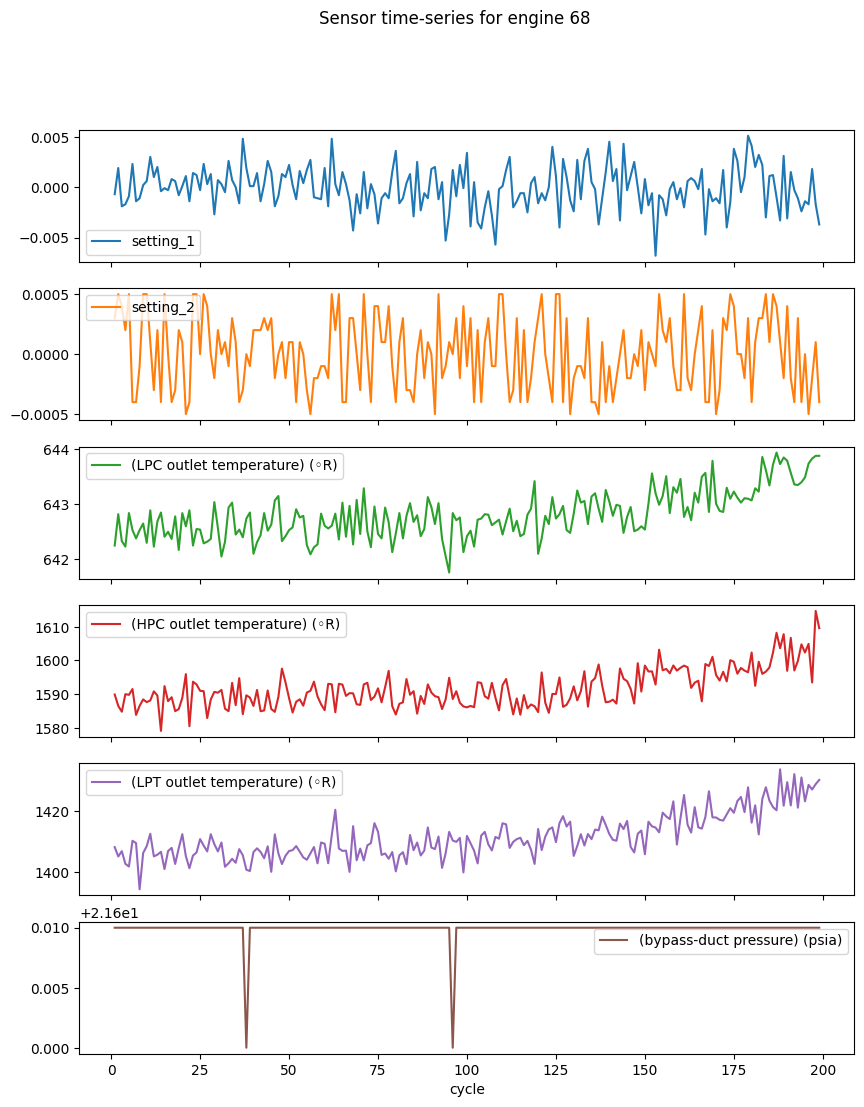

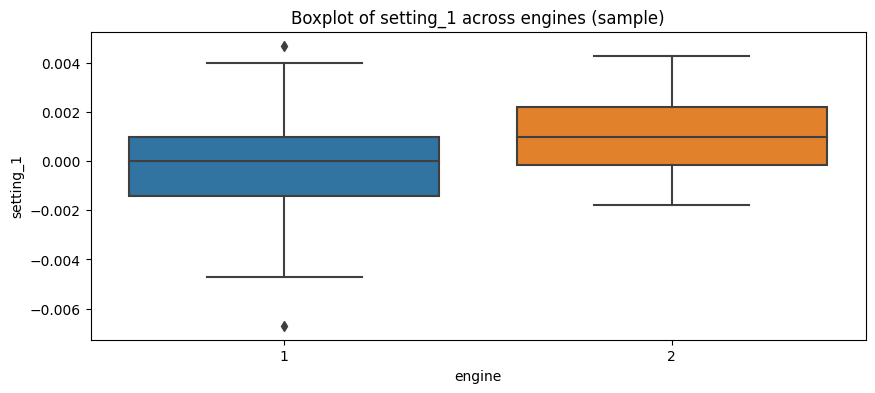

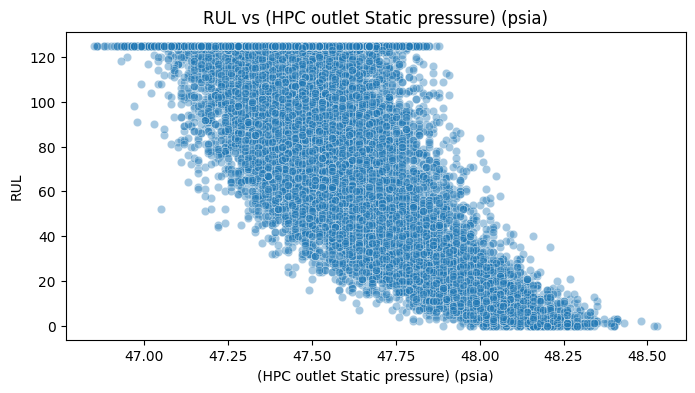

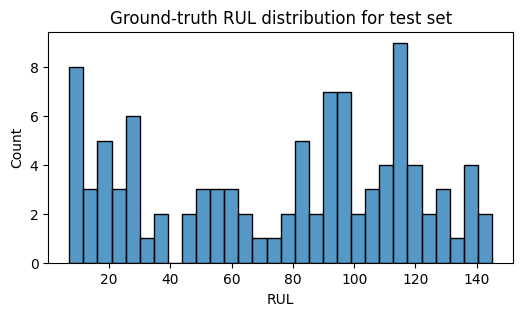

In [6]:
def eda_summary(df_train, df_test, df_test_RUL, save_plots=False, out_dir='eda_plots'):
    os.makedirs(out_dir, exist_ok=True)

    print('\n=== Basic info ===')
    print(df_train.info())

    print('\n=== Descriptive stats for sensors and settings ===')
    display_df = df_train.describe().T
    print(display_df)

    # distribution of RUL
    plt.figure(figsize=(8,4))
    sns.histplot(df_train['RUL'], bins=50, kde=True)
    plt.title('Distribution of RUL in training set')
    if save_plots: plt.savefig(os.path.join(out_dir, 'rul_distribution.png'))
    plt.show()

    # cycles per engine (run length)
    cycles_per_engine = df_train.groupby('engine')['cycle'].max()
    plt.figure(figsize=(10,4))
    sns.histplot(cycles_per_engine, bins=30)
    plt.title('Distribution of run length (cycles) per engine in train set')
    if save_plots: plt.savefig(os.path.join(out_dir, 'cycles_per_engine.png'))
    plt.show()

    # missing values
    plt.figure(figsize=(10,4))
    sns.heatmap(df_train.isnull(), cbar=False)
    plt.title('Missing values heatmap (train)')
    if save_plots: plt.savefig(os.path.join(out_dir, 'missing_heatmap_train.png'))
    plt.show()

    # correlations with RUL (top 10)
    corr = df_train.corr()['RUL'].drop('RUL').abs().sort_values(ascending=False)
    print('\nTop 12 features by absolute correlation with RUL:')
    print(corr.head(12))

    plt.figure(figsize=(10,5))
    corr.head(20).plot(kind='bar')
    plt.title('Top correlated features with RUL (absolute)')
    if save_plots: plt.savefig(os.path.join(out_dir, 'top_correlations.png'))
    plt.show()

    # full correlation heatmap for sensors (to see multicollinearity)
    sensor_cols = [c for c in df_train.columns if c not in ['engine','cycle','RUL']]
    plt.figure(figsize=(14,10))
    sns.heatmap(df_train[sensor_cols].corr(), cmap='RdBu_r', center=0)
    plt.title('Correlation heatmap (settings + sensors)')
    if save_plots: plt.savefig(os.path.join(out_dir, 'full_correlation.png'))
    plt.show()

    # plot sensor trends for a random engine sample
    sample_engine = random.choice(df_train['engine'].unique())
    print(f"\nPlotting sensor trends for engine {sample_engine}")
    sample_df = df_train[df_train['engine']==sample_engine].set_index('cycle')
    # plot a subset of sensors to avoid clutter
    sensors_to_plot = sensor_cols[:6]
    sample_df[sensors_to_plot].plot(subplots=True, figsize=(10, 2*len(sensors_to_plot)), layout=(len(sensors_to_plot),1))
    plt.suptitle(f'Sensor time-series for engine {sample_engine}')
    if save_plots: plt.savefig(os.path.join(out_dir, f'sensor_trends_engine_{sample_engine}.png'))
    plt.show()

    # compare distributions of one or two sensors across engines
    plt.figure(figsize=(10,4))
    sns.boxplot(x='engine', y=sensor_cols[0], data=df_train.iloc[:200])  # limit to first 200 rows for visibility
    plt.title(f'Boxplot of {sensor_cols[0]} across engines (sample)')
    if save_plots: plt.savefig(os.path.join(out_dir, 'boxplot_sensor_engine.png'))
    plt.show()

    # scatter RUL vs top correlated sensor
    top_sensor = corr.index[0]
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=df_train[top_sensor], y=df_train['RUL'], alpha=0.4)
    plt.title(f'RUL vs {top_sensor}')
    if save_plots: plt.savefig(os.path.join(out_dir, 'rul_vs_top_sensor.png'))
    plt.show()

    # test set RUL distribution
    plt.figure(figsize=(6,3))
    sns.histplot(df_test_RUL['RUL'], bins=30)
    plt.title('Ground-truth RUL distribution for test set')
    if save_plots: plt.savefig(os.path.join(out_dir, 'test_rul_distribution.png'))
    plt.show()


# Run EDA (it will show multiple plots)
eda_summary(df_train, df_test_max, df_test_RUL)